In [164]:
traj_data_save_path = 'trajectories.pkl'

import pickle


with open(traj_data_save_path, 'rb') as file:
    traj_data = pickle.load(file)



In [165]:
len(traj_data)

2088

In [169]:
len(feature[0])

20

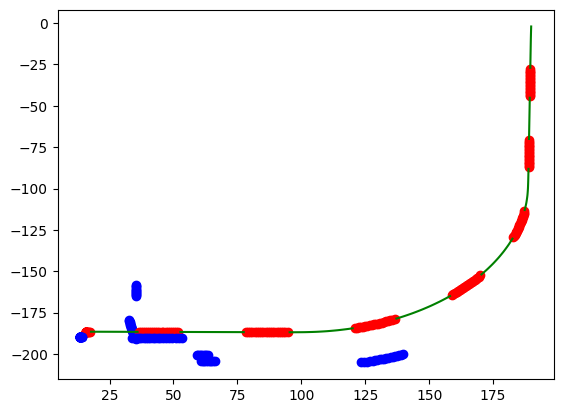

In [181]:
import matplotlib.pyplot as plt
for i in range(1, 10):
    feature = traj_data[i][0]
    label = np.array(traj_data[i][1])
    plt.plot(label[:, 0], label[:, 1], c='green')
    for j in range(len(feature)):
        trajectory = feature[j]
        # 提取第三列为1的点的坐标
        x_points = [point[0] for point in trajectory if point[2] == 1.0]
        y_points = [point[1] for point in trajectory if point[2] == 1.0]
        if j ==0:
            plt.scatter(x_points, y_points, c='red')
        else:
            plt.scatter(x_points, y_points, c='blue')



In [25]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

class CarlaDataset(Dataset):
    def __init__(self, traj_path=None, map_path=None):
        traj_path = './trajectories.pkl'
        map_path = './map_dict.pkl'
        self.data = pickle.load(open(traj_file, 'rb'))
        self.map_dict = pickle.load(open(map_file, 'rb'))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        traj, label = self.data[index]
        traj = torch.tensor(traj.copy())
        label = torch.tensor(label.copy())

        # 获取target第19帧的坐标
        target_coordinate = traj[0][-1][:2].numpy().tolist()
        # 计算每个字典中坐标与 target_coordinate 的欧氏距离
        distances = {key: np.linalg.norm(np.array(target_coordinate) - np.array(key)) for key in map_dict.keys()}
        # 找到最小距离对应的字典的value
        closest_coordinate = min(distances, key=distances.get)
        closest_value = map_dict[closest_coordinate]

        lane_list = [torch.tensor(df[['x', 'y']].values, dtype=torch.float32) for df in closest_value]
        return traj, lane_list, label

In [28]:
dataset = CarlaDataset()
from sklearn.model_selection import train_test_split
# 划分数据集
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42) 

AttributeError: 'list' object has no attribute 'numpy'